In [1]:
# Importing basic libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Familiarising with NumPy and MatplotLib
def f(x):
    return 4*x**2-6*x+20 

xs=np.arange(-10,10,.20)
ys=f(xs)

print(xs[0:5],ys[0:5])

[-10.   -9.8  -9.6  -9.4  -9.2] [480.   462.96 446.24 429.84 413.76]


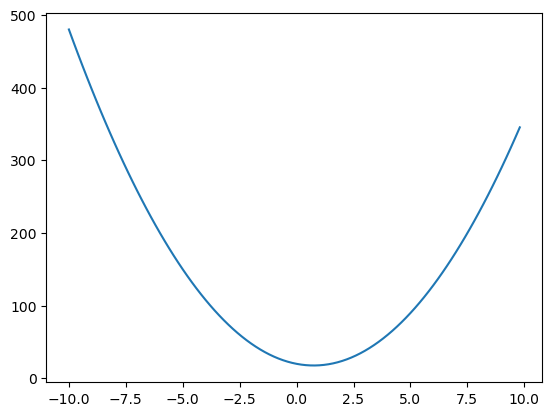

In [3]:
plt.plot(xs,ys)
plt.show()

In [4]:
# The derivative of x
h=.0000001
x=-1
(f(x+h)-f(x))/h

-13.999999595171175

In [ ]:
class Value:
    
    # structure of our datatype Value
    def __init__(self,data,_children=(),_op="",label=""):
        self.data= data
        self.grad= 0.0 # holds the gradient of output with respect to self {by default 0.0}
        self._backward= lambda : None
        self._prev= set(_children)
        self._op= _op
        self.label= label
    
    def __repr__(self):
        return f"(Value={self.data})"
    
    # basic operations available on the datatype 
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data + other.data,(self,other),"+")

        def _backward(): 
            self.grad+= 1.0 *out.grad
            other.grad+=1.0 *out.grad

        out._backward=_backward
        return out
    # in every backward function the grads are appended 
    # in case of multivariable differentiation 
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)


    def __radd__(self,other):
        return self+other

    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad

        out._backward=_backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float values in pow"
        out=Value(self.data**other,(self,),f"**{other}")

        def _backward():
            self.grad+= other*(self.data ** (other -1)) *out.grad

        out._backward=_backward

        return out


    def __truediv__(self,other):
        return self * other **-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self+(-other)

    # defining our tanh function
    def tanh(self):
        x=self.data
        t=((math.exp(2*x)-1)/(math.exp(2*x)+1))
        out=Value(t,(self,),"tanh")
        def _backward():
            self.grad+=(1-t**2) * out.grad
        out._backward=_backward
        return out
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),"exp")
        def _backward():
            self.grad+=out.data * out.grad
        out._backward=_backward
        return out

    # function to backpropagate from a selcted node 
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
    # here we are collecting the nodes in a bottom to top manner
        build_topo(self)

        topo[-1].grad=1.0 # generalised here as derivate of "a" wrt "a" is 1.0

        for node in reversed(topo): # reversed coz why not :) {the backpropagation goes from top to bottom that's why}
            node._backward()

In [ ]:
# making a basic network with our datatypes 
a=Value(2.0,label="a")
b=Value(3.0,label="b")
c=a*b;c.label="c"
d=Value(-7.0,label="d")
e=c+d;e.label="e"
f=Value(-5.0,label="f")
L=(e*f);L.label="L"

In [ ]:
print(L) # final value of our output
print(L._op) # last operation (out of valid operations) performed to obtain the output
print(L._prev) # prints two values due to which the output got its value

(Value=5.0)
*
{(Value=-1.0), (Value=-5.0)}


In [ ]:
# block to draw nodes and edges 
from graphviz import Digraph

def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot=Digraph(format="svg",graph_attr={"rankdir":"LR"})
    nodes,edges=trace(root)

    for n in nodes:
        uid=str(id(n))

        dot.node(name=uid,label= "{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape="record")

        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

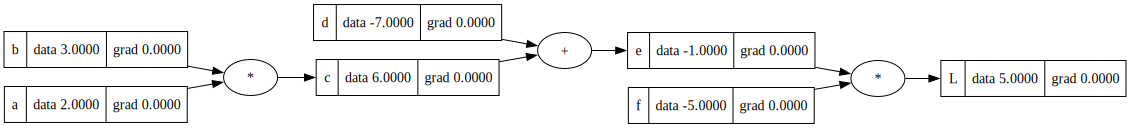

In [ ]:
# making the digram where the final node is L
draw_dot(L)

Manually filling the gradients

In [ ]:
def give_me_the_gradient():

    h=0.0001 # the small change h
    
    a=Value(2.0,label="a")
    b=Value(3.0,label="b")
    c=a*b;c.label="c"
    d=Value(-7.0,label="d")   # no change in the structure of L
    e=c+d;e.label="e"
    f=Value(-5.0,label="f")
    L=e*f;L.label="L"
    L1=L.data
# to measure out the derivative when h is added in any of the basic nodes
    a=Value(2.0,label="a")
    b=Value(3.0+h,label="b") # h is added in b
    c=a*b;c.label="c"
    d=Value(-7.0,label="d")
    e=c+d;e.label="e"
    f=Value(-5.0,label="f")
    L=e*f;L.label="L"
    L2=L.data

    print((L2-L1)/h) # prints the derivative wrt b



In [11]:
give_me_the_gradient()

-10.000000000021103


In [12]:
# filling up all the derivatives 
L.grad=1.0
f.grad=e.data
e.grad=f.data
d.grad=-5.0
c.grad=-5.0
a.grad=-15.0
b.grad=-10.0

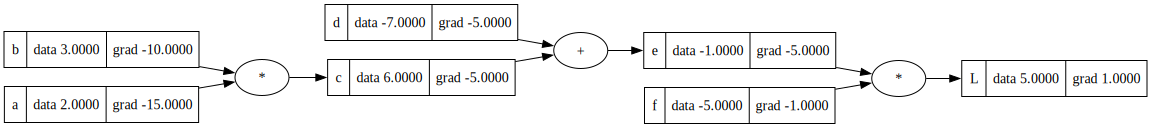

In [13]:
draw_dot(L)

In [ ]:
# building a basic neural network whose output is generated by our tanh function

#inputs
x1=Value(2.0,label="x1")
x2=Value(1.0,label="x2")
#weights 
w1=Value(-5.0,label="w1")
w2=Value(2.0,label="w2")
#bias
b=Value(6.881375334453462,label="bias")
# bias + x1*w1 + x2*w2
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label="x1w1 * x2w2"
n=x1w1x2w2 + b ; n.label="n"
o=n.tanh();o.label="output"

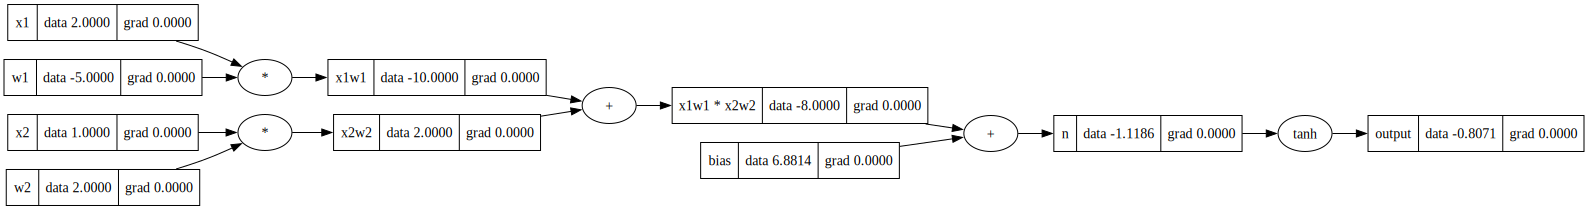

In [15]:
draw_dot(o)

Manually done back-propagation

In [16]:

# o.grad=1.0 # as its the last node

# n.grad=1-(o.data*o.data) # as d(tanh(x))/dx=1-(tanh(x)**2)
# distributed as additive for n 

# b.grad=n.grad
# x1w1x2w2.grad=n.grad

# # distributed as additive for x1w1x2w2

# x1w1.grad=x1w1x2w2.grad
# x2w2.grad=x1w1x2w2.grad

# # the grads of inputs and weights

# x1.grad=w1.data*x1w1.grad
# w1.grad=x1.data*x1w1.grad

# x2.grad=w2.data*x2w2.grad
# w2.grad=x2.data*x2w2.grad



A different way of performing the back propagation without our backward method

In [17]:

# o.grad=1.0
# ls=[o,n,x1w1x2w2,b,x1w1,x2w2]
# for a in ls:
#     a._backward()

# as u noticed its cumbersome as we need to manually write the top to bottom nodes :(

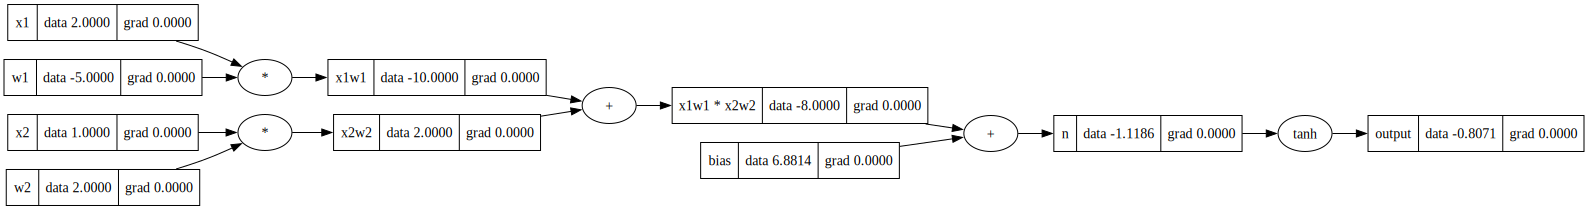

In [18]:
draw_dot(o)

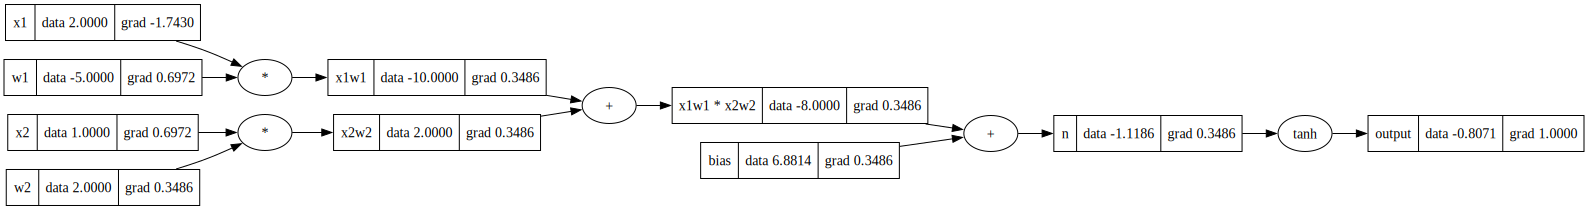

In [19]:
o.backward() #performed the backpropagation here
draw_dot(o) #noticed any change :) ?

Making the output as the result of e**x expressions

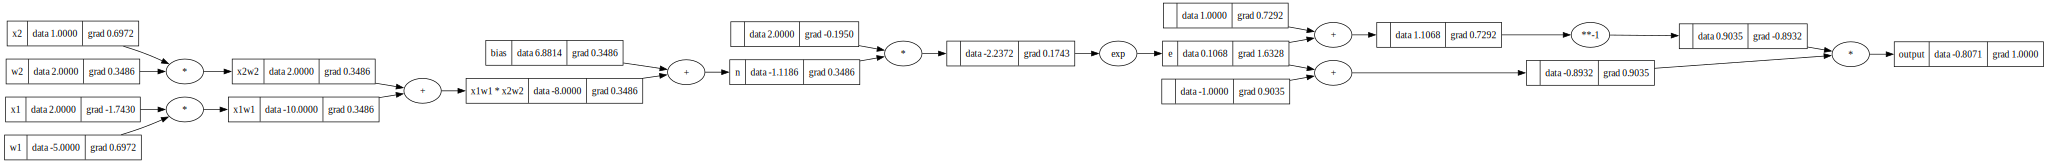

In [20]:
#inputs
x1=Value(2.0,label="x1")
x2=Value(1.0,label="x2")
#wieghts 
w1=Value(-5.0,label="w1")
w2=Value(2.0,label="w2")
#bias
b=Value(6.881375334453462,label="bias")
# bias + x1*w1 + x2*w2
x1w1=x1*w1;x1w1.label="x1w1"
x2w2=x2*w2;x2w2.label="x2w2"
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label="x1w1 * x2w2"
n=x1w1x2w2 + b ; n.label="n"
e=(2*n).exp();e.label="e"
o=(e-1)/(e+1)
o.label="output"
o.backward()
draw_dot(o)

Definin' the basic structure of our neurons, layer of neurons and multi-level perceptron

In [21]:
class Neuron:
    def __init__(self,nin):
        #weights for each Value inputs
        self.w=[Value(random.uniform(-1,1)) for _ in range (nin)]
        #bias
        self.b=Value(random.uniform(-1,1)) 

    # when called sums the wieghts 
    # with the inputs and bias 
    # applies the tanh activation 
    # before giving the output
    def __call__(self,x): 
        act=sum(wi*xi for wi,xi in zip(self.w,x)) +self.b
        out =act.tanh()
        return out
    
    def parameters(self):
        return self.w+[self.b]
    

class Layer: # contains multiple Neuron instances
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: # represents a full feedforward neural network
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range (len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [22]:
# an illustration showing how to use 

x=[2.0,3.0,-1.0] # list of inputs to be given to the MLP

n=MLP(3,[4,4,1]) # initailaizing a MLP with 3 inputs, 
# 2 layer instances of 4 neurons and 1 output :)

print(n(x)) # getting the result

n(x).backward()

# before executing ans me this what could be its size????????
# draw_dot(n(x)) 

(Value=-0.9465798186487034)


Performing gradient descent manually

In [23]:
# inputs
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [1.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys=[1.0,-1.0,-1.0,1.0] #desired targets

In [24]:
print(len(n.parameters()))

41


In [25]:
y_pred=[n(x) for x in xs]
y_pred

[(Value=-0.9465798186487034),
 (Value=-0.9355789549984412),
 (Value=-0.7775202153053972),
 (Value=-0.8487635105360017)]

In [26]:
n.layers[0].neurons[1].w[0].grad #checking the weights and biases

0.048182732929306686

Performing Gradient descent

In [27]:
for k in range (20):

    # forward pass
    y_pred=[n(x) for x in xs] # predictions
    loss=sum([(yout-ygt)**2 for ygt , yout in zip(ys,y_pred)])

    # backward pass
    for p in n.parameters():
        p.grad=0.0
    
    loss.backward()

    for p in n.parameters():
        p.data+= -0.5*p.grad # the signs and values may change acc. to ur weights and grads

    print(k+1,loss.data)


1 7.26074683389667
2 6.617750965034433
3 6.5647083338328915
4 3.5395915042189245
5 3.1756047298027776
6 3.9998927758156286
7 3.999851543146793
8 3.999756366442591
9 3.9993794361733186
10 3.9862674100639746
11 3.604297184220968e-11
12 3.604297178864198e-11
13 3.60429717369018e-11
14 3.6042971683334106e-11
15 3.604297163002399e-11
16 3.604297157454955e-11
17 3.6042971520981855e-11
18 3.604297146928129e-11
19 3.604297141673635e-11
20 3.604297136236388e-11


In [28]:
y_pred #predictions after performing gradient descent

[(Value=0.9999999108019013),
 (Value=-0.999995215560436),
 (Value=-0.9999963756108543),
 (Value=0.9999999108011167)]

Repeat the gradient descent part until you reach close to your desired results and if the neural network gives a constant output then re run from the block where the staructure of MLP is defined so as the weights get reset and you can restart on your descent again :)